In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [123]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 10

#max steps per episode
MAX_STEPS = 500

#score agent needs for environment to be solved
SOLVED_SCORE = -13

#device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [124]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):

    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)

    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)

        #relu activation
        x = F.relu(x)

        #actions
        actions = self.output_layer(x)

        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)

        return action_probs

In [125]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):

    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()

        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value

In [126]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment

    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''

    #convert state to float tensor, add 1 dimension, allocate tensor on device
    # print(type(state[0]))
    # print(state[0])
    #OLD
    #state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    #NEW
    state = torch.tensor([state], dtype=torch.float).unsqueeze(0).to(DEVICE)

    #use network to predict action probabilities
    action_probs = network(state)
    state = state.detach()  
    
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    #return action
    return action.item(), m.log_prob(action)

In [127]:
#Make environment
env = gym.make('CliffWalking-v0')#, render_mode='human')

#OLD Init network
#policy_network = PolicyNetwork(np.array(env.observation_space.n, env.action_space.n).to(DEVICE)
#stateval_network = StateValueNetwork(np.array(env.observation_space.n)).to(DEVICE)
#NEW Init network using observation space  value of 1.  The observation space is a single value representing the current state from 0-47
policy_network = PolicyNetwork(1, env.action_space.n).to(DEVICE)
stateval_network = StateValueNetwork(1).to(DEVICE)

#Init optimizer
policy_optimizer = optim.SGD(policy_network.parameters(), lr=0.001)
stateval_optimizer = optim.SGD(stateval_network.parameters(), lr=0.001)

In [128]:
#track scores
scores = []

#track recent scores
recent_scores = deque(maxlen = 100)

#run episodes
for episode in tqdm_notebook(range(NUM_EPISODES)):

    #init variables
    state, _ = env.reset()
    #print(state)
    done = False
    score = 0
    I = 1

    #run episode, update online
    for step in range(MAX_STEPS):

        #get action and log probability
        action, lp = select_action(policy_network, state)

        #step with action
        # print(env.step(action))
        new_state, reward, done, t, tt = env.step(action)

        #NEW - added because cliffwalking env does not return done as True when agent falls off cliff
        #if reward == -100:
        #    done = True
        
        #NEW - check if agent has reached the end of the grid
        if new_state == 47:
            done = True

        #update episode scor
        score += reward

        #print(f"episode: {episode}, Step: {step}, State: {state}, Action: {action}, Reward: {reward}, New State: {new_state}, Done: {done}, Score: {score}, t: {t}, tt: {tt}")

        reward_tensor = torch.tensor([reward]).float().unsqueeze(0).to(DEVICE)

        #get state value of current state
        #OLD
        #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        #NEW
        state_tensor = torch.tensor([state], dtype=torch.float).unsqueeze(0).to(DEVICE)
        state_val = stateval_network(state_tensor)

        #get state value of next state
        #OLD
        #new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)
        #NEW
        new_state_tensor = torch.tensor([new_state], dtype=torch.float).unsqueeze(0).to(DEVICE)
        new_state_val = stateval_network(new_state_tensor)

        #if terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)

        #calculate value function loss with MSE
        td_target = reward_tensor + DISCOUNT_FACTOR * new_state_val.item()
        val_loss = F.mse_loss(state_val, td_target.detach())
        #val_loss *= I

        #calculate policy loss
        advantage = td_target - state_val
        policy_loss = -lp * advantage.detach()
        #policy_loss *= I

        #Backpropagate policy
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()

        #Backpropagate value
        stateval_optimizer.zero_grad()
        val_loss.backward()
        stateval_optimizer.step()

        if done:
            print(f"Episode {episode} finished after {step} steps at state {new_state} with score {score}")
            break

        #move into new state, discount I
        state = new_state
        I *= DISCOUNT_FACTOR

    #append episode score
    scores.append(score)
    recent_scores.append(score)

    #early stopping if we meet solved score goal
    if np.array(recent_scores).mean() >= SOLVED_SCORE:
        break



C:\Users\brian\AppData\Local\Temp\ipykernel_17960\1333527279.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\brian\AppData\Roaming\Python\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


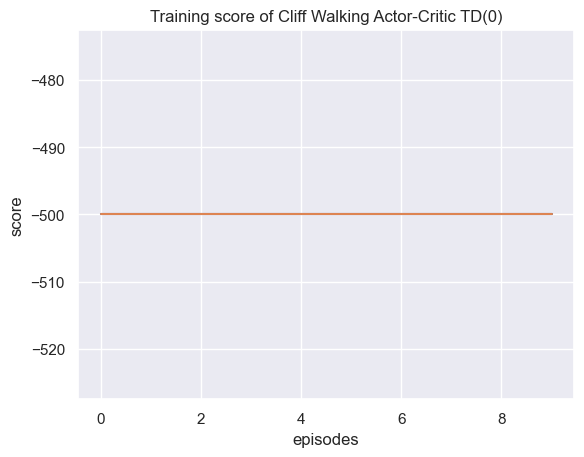

In [129]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of Cliff Walking Actor-Critic TD(0)')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [130]:
# done = False
# state, _ = env.reset()
# scores = []

# for _ in tqdm_notebook(range(5)):
#     state, _ = env.reset()
#     # print(state)
#     done = False
#     score = 0
#     while not done:
#         env.render()
#         action, lp = select_action(policy_network, state)
#         new_state, reward, done, info, _ = env.step(action)
        
#         #NEW - added because cliffwalking env does not return done as True when agent falls off cliff
#         if reward == -100:
#             done = True
        
#         #NEW - check if agent has reached the end of the grid
#         if new_state == 47:
#             done = True

#         score += reward
#         state = new_state
#     scores.append(score)
# env.close()

In [131]:
env.close()

In [132]:
np.array(scores).mean()

-500.0